In [ ]:
!pip install pandas numpy matplotlib statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 7.9 MB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Synthetic Time Series Generation

Creating monthly data over 5 years with linear trend, seasonal pattern, and random noise.

**Components:**
- Trend: baseline=100, slope=2
- Seasonality: amplitude=20, period=12 months
- Noise: σ=5

In [ ]:
# Time series parameters
BASELINE = 100
SLOPE = 2
AMPLITUDE = 20
PERIOD = 12
NOISE_STD = 5
N_YEARS = 5

# Generate time points (by months)
n_points = N_YEARS * 12
time_index = np.arange(1, n_points + 1)

# Set seed for reproducibility
np.random.seed(42)

# Build components
trend_component = BASELINE + SLOPE * time_index
seasonal_component = AMPLITUDE * np.sin(2 * np.pi * time_index / PERIOD)
noise_component = np.random.normal(0, NOISE_STD, n_points)

# Combine components
time_series = trend_component + seasonal_component + noise_component

print(f"Generated {n_points} observations")
print(f"\nFirst 10 values: {time_series[:10]}")

Generated 60 observations

First 10 values: [114.48357077 120.62918657 129.23844269 132.93565736 118.82923313
 110.82931522 111.89606408 102.51666557  95.65262807 105.39229214]


In [4]:
# Create structured dataframe
dates = pd.date_range(start='2020-01-01', periods=n_points, freq='MS')

ts_data = pd.DataFrame({
    'date': dates,
    'time': time_index,
    'trend': trend_component,
    'seasonal': seasonal_component,
    'noise': noise_component,
    'value': time_series
})

print("Time series dataframe:")
print(ts_data.head(10))
print("\nSummary statistics:")
print(ts_data['value'].describe())

Time series dataframe:
        date  time  trend      seasonal     noise       value
0 2020-01-01     1    102  1.000000e+01  2.483571  114.483571
1 2020-02-01     2    104  1.732051e+01 -0.691322  120.629187
2 2020-03-01     3    106  2.000000e+01  3.238443  129.238443
3 2020-04-01     4    108  1.732051e+01  7.615149  132.935657
4 2020-05-01     5    110  1.000000e+01 -1.170767  118.829233
5 2020-06-01     6    112  2.449294e-15 -1.170685  110.829315
6 2020-07-01     7    114 -1.000000e+01  7.896064  111.896064
7 2020-08-01     8    116 -1.732051e+01  3.837174  102.516666
8 2020-09-01     9    118 -2.000000e+01 -2.347372   95.652628
9 2020-10-01    10    120 -1.732051e+01  2.712800  105.392292

Summary statistics:
count     60.000000
mean     160.226727
std       35.553286
min       95.652628
25%      132.033804
50%      160.574461
75%      190.192702
max      224.877726
Name: value, dtype: float64


## Component Visualization

Plotting the complete series and its individual components.

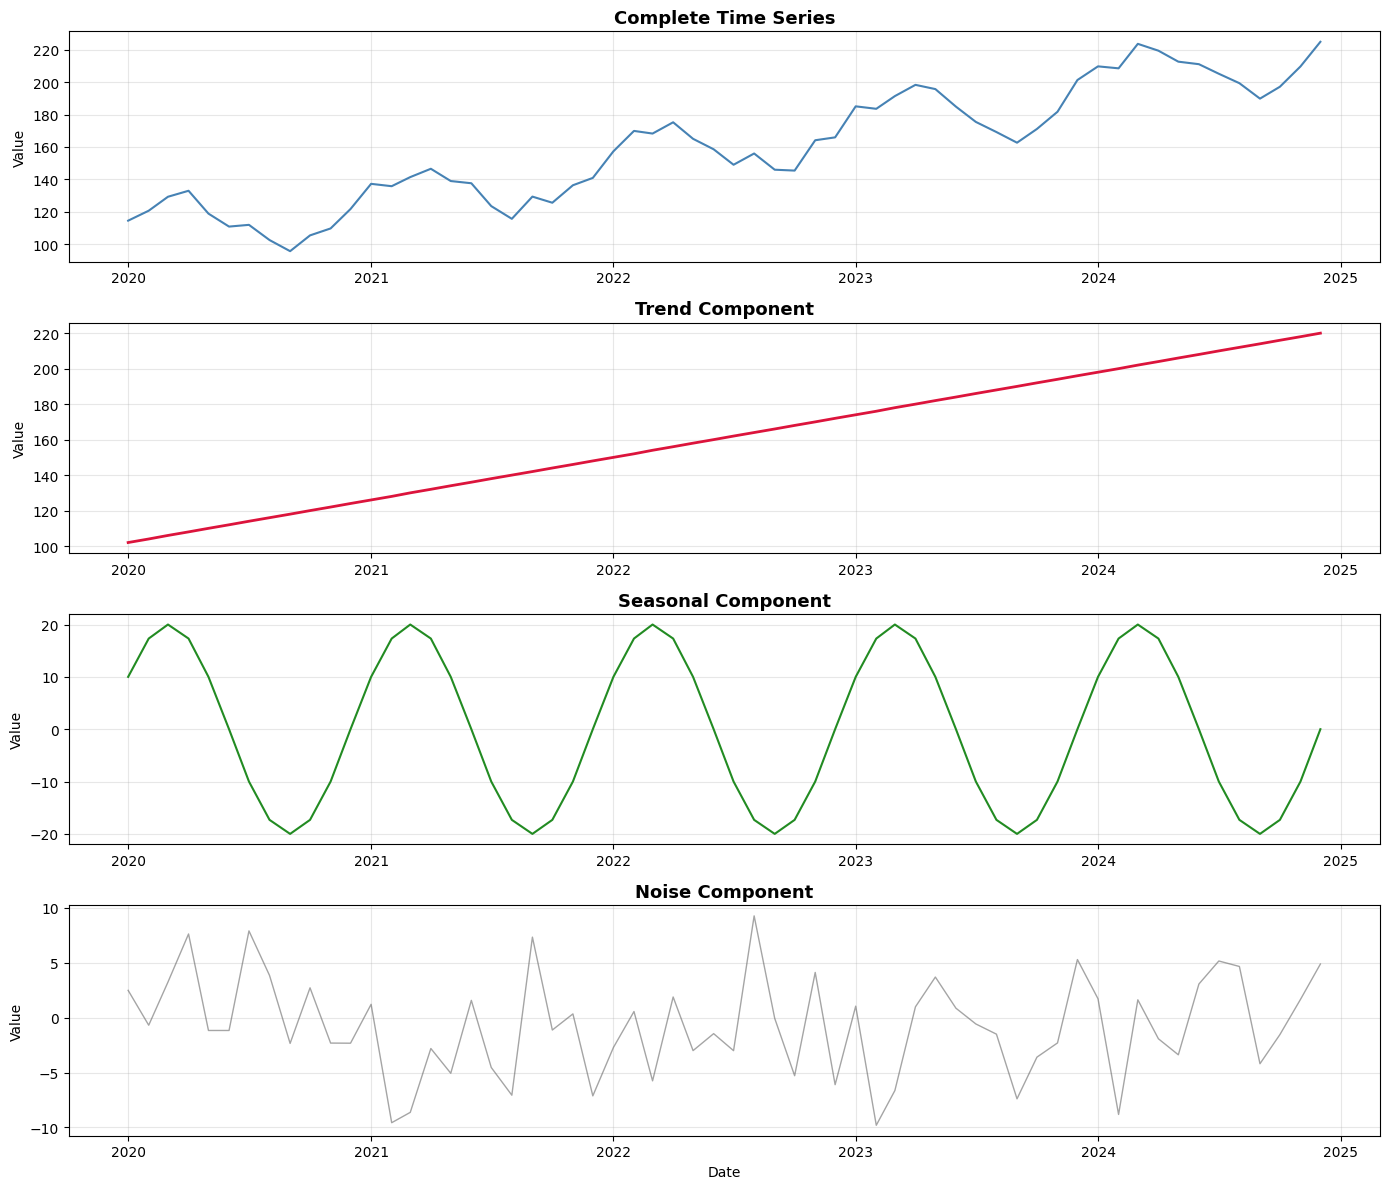

In [5]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Complete series
axes[0].plot(ts_data['date'], ts_data['value'], 'steelblue', linewidth=1.5)
axes[0].set_title('Complete Time Series', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.3)

# Trend
axes[1].plot(ts_data['date'], ts_data['trend'], 'crimson', linewidth=2)
axes[1].set_title('Trend Component', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Value')
axes[1].grid(alpha=0.3)

# Seasonality
axes[2].plot(ts_data['date'], ts_data['seasonal'], 'forestgreen', linewidth=1.5)
axes[2].set_title('Seasonal Component', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Value')
axes[2].grid(alpha=0.3)

# Noise
axes[3].plot(ts_data['date'], ts_data['noise'], color='dimgray', alpha=0.6, linewidth=1)
axes[3].set_title('Noise Component', fontsize=13, fontweight='bold')
axes[3].set_ylabel('Value')
axes[3].set_xlabel('Date')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Autocorrelation Analysis

Examining ACF and PACF to identify patterns and potential model orders.

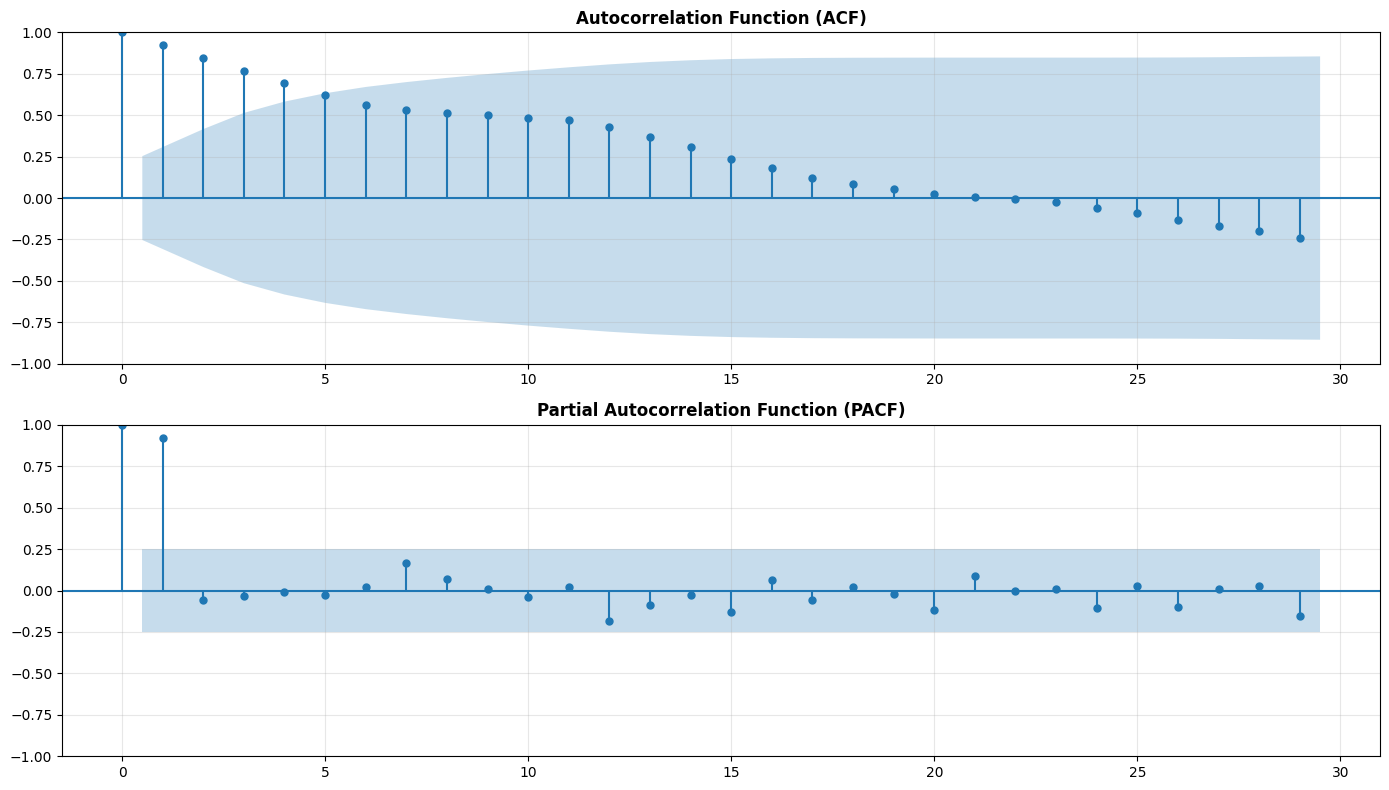

In [6]:
# Determine appropriate lag count
max_lags = min(40, len(ts_data) // 2 - 1)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Autocorrelation function
plot_acf(ts_data['value'], lags=max_lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Partial autocorrelation function
plot_pacf(ts_data['value'], lags=max_lags, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Stationarity Test

Using Augmented Dickey-Fuller test to check for stationarity.

In [7]:
# Perform ADF test
adf_result = adfuller(ts_data['value'])

print("=" * 65)
print("Augmented Dickey-Fuller Test Results")
print("=" * 65)
print(f"Test Statistic:        {adf_result[0]:.4f}")
print(f"P-value:               {adf_result[1]:.4f}")
print(f"Lags Used:             {adf_result[2]}")
print(f"Observations:          {adf_result[3]}")
print("\nCritical Values:")
for significance, critical_val in adf_result[4].items():
    print(f"  {significance:>5}: {critical_val:>8.3f}")

print("\n" + "=" * 65)
if adf_result[1] < 0.05:
    print("Result: Series is STATIONARY (p-value < 0.05)")
else:
    print("Result: Series is NON-STATIONARY (p-value >= 0.05)")
print("=" * 65)

Augmented Dickey-Fuller Test Results
Test Statistic:        1.1843
P-value:               0.9959
Lags Used:             10
Observations:          49

Critical Values:
     1%:   -3.571
     5%:   -2.923
    10%:   -2.599

Result: Series is NON-STATIONARY (p-value >= 0.05)


## SARIMA Modeling

Fitting Seasonal ARIMA model: SARIMA(1,0,1)(1,0,1)[12]

In [8]:
# Fit SARIMA model
print("Fitting SARIMA(1,0,1)(1,0,1)[12] model...")

sarima_model = SARIMAX(
    ts_data['value'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12)
)

fitted_model = sarima_model.fit(disp=False)

print("\n" + "=" * 65)
print("Model Summary")
print("=" * 65)
print(fitted_model.summary())

Fitting SARIMA(1,0,1)(1,0,1)[12] model...

Model Summary
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -207.890
Date:                            Wed, 10 Dec 2025   AIC                            425.780
Time:                                    22:17:24   BIC                            436.251
Sample:                                         0   HQIC                           429.876
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9979      0.003    347.864      0.000   


Residual Diagnostics:


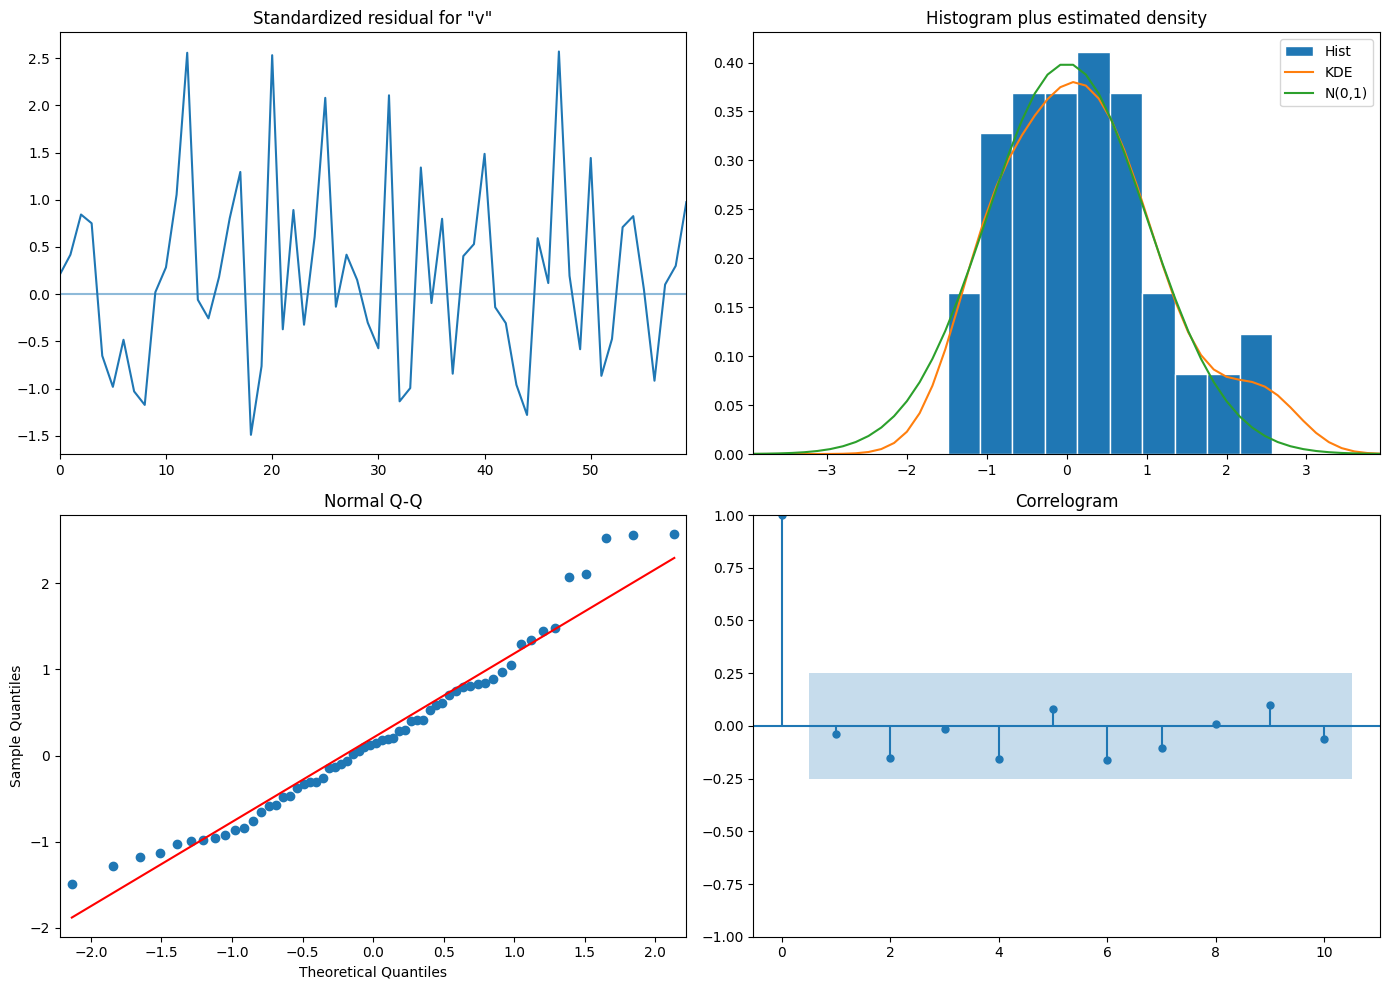

In [9]:
# Diagnostic plots
print("\nResidual Diagnostics:")
fitted_model.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

## Forecasting

Generating 12-month ahead predictions with confidence intervals.

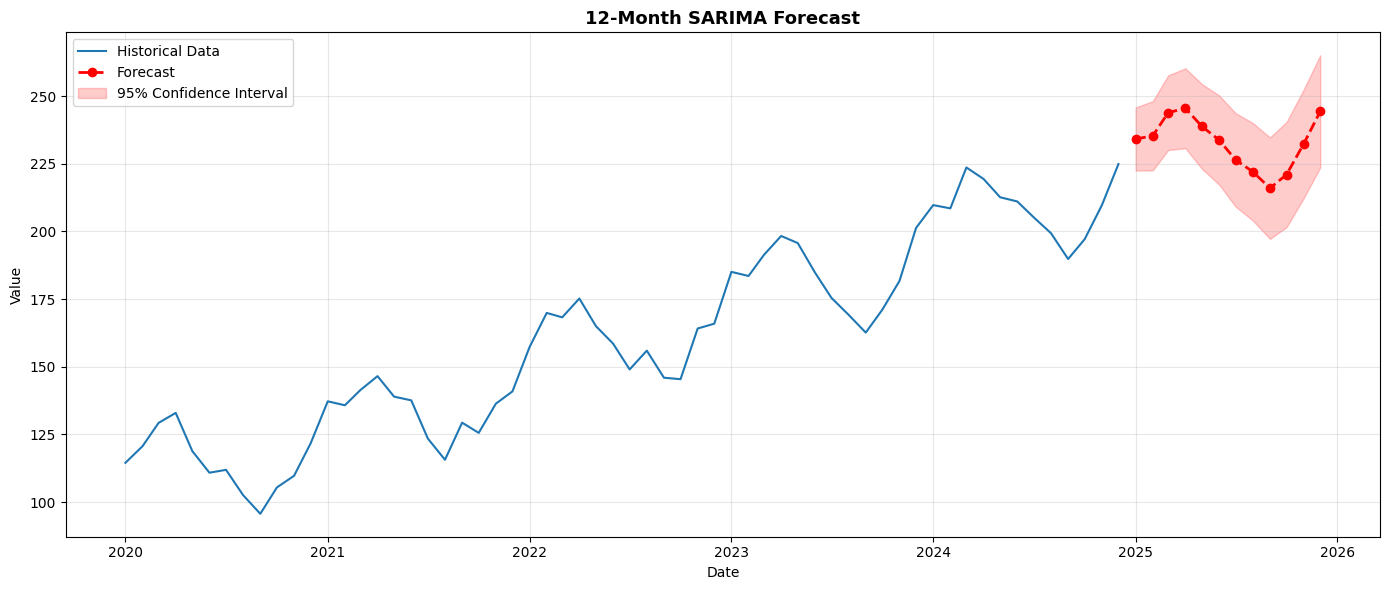

In [10]:
# Generate forecast
FORECAST_HORIZON = 12

forecast_output = fitted_model.get_forecast(steps=FORECAST_HORIZON)
forecast_values = forecast_output.predicted_mean
forecast_intervals = forecast_output.conf_int()

# Create forecast dates
forecast_dates = pd.date_range(
    start=ts_data['date'].iloc[-1] + pd.DateOffset(months=1),
    periods=FORECAST_HORIZON,
    freq='MS'
)

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(ts_data['date'], ts_data['value'], label='Historical Data', linewidth=1.5)
plt.plot(forecast_dates, forecast_values, 'r--', marker='o', label='Forecast', linewidth=2)
plt.fill_between(
    forecast_dates,
    forecast_intervals.iloc[:, 0],
    forecast_intervals.iloc[:, 1],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.title('12-Month SARIMA Forecast', fontsize=13, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Display forecast table
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values.values,
    'Lower_95%': forecast_intervals.iloc[:, 0].values,
    'Upper_95%': forecast_intervals.iloc[:, 1].values
})

print("\nForecast Table (12 months):")
print(forecast_df.to_string(index=False))

# Calculate forecast statistics
print(f"\nForecast Statistics:")
print(f"  Mean:   {forecast_values.mean():.2f}")
print(f"  Std:    {forecast_values.std():.2f}")
print(f"  Min:    {forecast_values.min():.2f}")
print(f"  Max:    {forecast_values.max():.2f}")


Forecast Table (12 months):
      Date   Forecast  Lower_95%  Upper_95%
2025-01-01 234.141170 222.472521 245.809819
2025-02-01 235.319525 222.534610 248.104441
2025-03-01 243.870659 230.063726 257.677592
2025-04-01 245.503033 230.748716 260.257350
2025-05-01 238.787965 223.147314 254.428616
2025-06-01 233.786010 217.310205 250.261816
2025-07-01 226.404295 209.137072 243.671518
2025-08-01 222.051144 204.030463 240.071824
2025-09-01 215.979393 197.238623 234.720163
2025-10-01 220.971574 201.540360 240.402788
2025-11-01 232.330880 212.235800 252.425960
2025-12-01 244.348625 223.613691 265.083559

Forecast Statistics:
  Mean:   232.79
  Std:    9.73
  Min:    215.98
  Max:    245.50
